In [ ]:
# 구글 드라이브와 연동하는 방법 입니다. 
# Google File Drive Stream 접근을 허용해야 합니다.
from google.colab import auth
auth.authenticate_user()

# 구글 드라이브 mount
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# 1. 홈 디렉토리에 datasets 폴더 생성 후, 그 안에 cats_and_dogs_small 폴더를 생성 합니다.
# 2. cats_and_dogs_small 안에 train, test, validation 폴더가 위치 하도록 압축을 풉니다.
%cd gdrive/My Drive/datasets/cats_and_dogs_small

/content/gdrive/My Drive/datasets/cats_and_dogs_small


In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255로 스케일을 조정합니다
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)



base_dir = '/content/gdrive/My Drive/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
# validation_dir = os.path.join(base_dir, 'validation')
# test_dir = os.path.join(base_dir, 'test')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=20,
        class_mode='categorical')

# validation_generator = test_datagen.flow_from_directory(
#         validation_dir,
#         target_size=(224, 224),
#         batch_size=20,
#         class_mode='binary')

Using TensorFlow backend.


Found 2000 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print 'Batch size:', data_batch.shape
    print 'Label size:', labels_batch.shape
    break

Batch size: (20, 224, 224, 3)
Label size: (20, 2)


In [ ]:
labels_batch

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
#  This code cell shows how to utilize VGG16 model by combining Dense layer at the end of the network 
from keras.layers import Input, Dense, GlobalAveragePooling2D, Flatten
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras import layers
from keras import models

VGGNet = VGG16()
VGGNet.summary()

Using TensorFlow backend.


553467904/553467096 [==============================] - 13s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [ ]:
# We will not update VGG pre-trained model, only added Dense layers will be trained from the scratch
for layer in VGGNet.layers:
  layer.trainable = False

In [ ]:
vgg_maxpool5 = VGGNet.get_layer('block5_pool').output

In [ ]:
block6_conv1 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(vgg_maxpool5)
block6_conv2 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(block6_conv1)
block6_conv3 = layers.Conv2D(1024, (3,3), activation='relu', padding='same')(block6_conv2)
block6_pool  = layers.MaxPool2D((2,2))(block6_conv3)

In [ ]:
Feature_Flatten = Flatten()(block6_pool)

In [ ]:
dense = Dense(1024, name='dense', activation='relu')(Feature_Flatten)
predictions = Dense(2, activation='softmax')(dense)

In [ ]:
New_VGGmodel = Model(inputs=VGGNet.input, outputs=predictions)
New_VGGmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

New_VGGmodel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
history = New_VGGmodel.fit_generator(
    train_generator,
#     validation_data=validation_generator, 
#     validation_steps=10,
    steps_per_epoch=10,
    epochs=5
)

Epoch 1/5
10/10 [==============================] - 93s 9s/step - loss: 22.0710 - accuracy: 0.5550
Epoch 2/5
10/10 [==============================] - 80s 8s/step - loss: 2.8491 - accuracy: 0.5800
Epoch 3/5
10/10 [==============================] - 84s 8s/step - loss: 1.5493 - accuracy: 0.6600
Epoch 4/5
10/10 [==============================] - 90s 9s/step - loss: 1.6624 - accuracy: 0.6650
Epoch 5/5
10/10 [==============================] - 104s 10s/step - loss: 0.8795 - accuracy: 0.7700


In [ ]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [ ]:
pip install flickrapi

     |████████████████████████████████| 61kB 4.3MB/s 


In [ ]:
from flickrapi import FlickrAPI

FLICKER_KEY = '505e8c2b05e8b5aa51766a43fc4bc7a7'
FLICKER_SECRET = '46b3ef2f43b04ac6'

flickr = FlickrAPI(FLICKER_KEY, FLICKER_SECRET, format='parsed-json')
extras='url_s'
cats = flickr.photos.search(text='kitten', per_page=5, extras=extras)
photos = cats['photos']

In [ ]:
photos

{u'page': 1,
 u'pages': 29244,
 u'perpage': 5,
 u'photo': [{u'farm': 66,
   u'height_s': 240,
   u'id': u'49918169172',
   u'isfamily': 0,
   u'isfriend': 0,
   u'ispublic': 1,
   u'owner': u'49998540@N03',
   u'secret': u'b28ff26c93',
   u'server': u'65535',
   u'title': u'\u3082\u3046\u3075\u304f\u308b\u307e\u308a\u306d\u3053 #\u306d\u3053 #\u732b #cat #gatto #chat #kitten',
   u'url_s': u'https://live.staticflickr.com/65535/49918169172_b28ff26c93_m.jpg',
   u'width_s': 194},
  {u'farm': 66,
   u'height_s': 240,
   u'id': u'49917854371',
   u'isfamily': 0,
   u'isfriend': 0,
   u'ispublic': 1,
   u'owner': u'91486426@N00',
   u'secret': u'd932e3c05e',
   u'server': u'65535',
   u'title': u'Aloe blooming in front of the temple',
   u'url_s': u'https://live.staticflickr.com/65535/49917854371_d932e3c05e_m.jpg',
   u'width_s': 160},
  {u'farm': 66,
   u'height_s': 240,
   u'id': u'49917766891',
   u'isfamily': 0,
   u'isfriend': 0,
   u'ispublic': 1,
   u'owner': u'147012678@N07',
   u's

In [ ]:
# import the necessary packages
import numpy as np
import urllib
import cv2

def url_to_image(url):
  # python 2
  resp = urllib.urlopen(url)
  
  # python 3
  # resp = urllib.request.urlopen(url)
  
  image = np.asarray(bytearray(resp.read()), dtype="uint8")
  image = cv2.imdecode(image, cv2.IMREAD_COLOR)

  return image

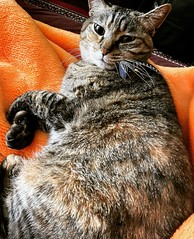

In [ ]:
from google.colab.patches import cv2_imshow

image_original_url = photos['photo'][0]['url_s']

image_temp = url_to_image(image_original_url)
cv2_imshow(image_temp)

In [ ]:
image_temp.shape

(239, 194, 3)

In [ ]:
resized_image = cv2.resize(image_temp, (224, 224))
print resized_image.shape

(224, 224, 3)


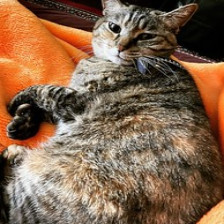

In [ ]:
cv2_imshow(resized_image)

In [ ]:
resized_image = np.expand_dims(resized_image, axis=0)
print resized_image.shape

(1, 224, 224, 3)


In [ ]:
result = New_VGGmodel.predict(resized_image)

In [ ]:
result

array([[1., 0.]], dtype=float32)

In [ ]:
# 0 -> [1, 0]
# 1 -> [0, 1]

In [ ]:
result = np.argmax(result)

In [ ]:
result

0

In [ ]:
print (train_generator.class_indices)

{'cats': 0, 'dogs': 1}


In [ ]:
New_VGGmodel.save('MyVGGNet_200521.h5')

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
# val_acc = history.history['val_acc']
loss = history.history['loss']
# val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
# plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

W1122 01:36:16.981764 139709344200576 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



NameError: ignored